## Experiment Setup

In [1]:
# Import Statements / Setup
from Dataset import Dataset
import matplotlib.pyplot as plt
import numpy as np
from preprocess_data import filter_genres
import sklearn
import tensorflow as tf
import time

from models.Model import Model
from models.CNNModel import CNNModel
from models.FCModel import FCModel
from models.LogisticRegression import LogisticRegression


%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def current_time_millis():
    return int(round(time.time() * 1000))

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load / Preprocess Data

In [2]:
small_dataset = False
np.random.seed(123456789) # Make ordering of data consistent b/w runs

# List of all genres
ALL_GENRES_LIST = [
    'Action', 'Adventure', 'Animation', 'Comedy',
    'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
    'History', 'Horror', 'Music', 'Mystery', 'Romance',
    'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western'
]

# List of genres which we will attempt to classify.
USED_GENRES_LIST = ALL_GENRES_LIST

# Load and Shuffle Data.
start_time = current_time_millis()
posters = np.load('movie_data/posters.npy') if not small_dataset else np.load('movie_data/posters_small.npy')
genres = np.load('movie_data/genres.npy') if not small_dataset else np.load('movie_data/genres_small.npy')
posters, genres = sklearn.utils.shuffle(posters, genres)
end_time = current_time_millis()
print('Loading Data took {0} seconds\n'.format((end_time-start_time)/1000.0))

# Remove genres which we are not attempting to classify
genres = filter_genres(ALL_GENRES_LIST, USED_GENRES_LIST, genres)
label_probabilities = np.mean(genres, axis=0, keepdims=True)
print('Fraction of examples which belong to genre:')
for i, genre in enumerate(USED_GENRES_LIST):
    print('{0} : {1:.2f}'.format(genre, label_probabilities[0][i]))

Loading Data took 5.423 seconds

Fraction of examples which belong to genre:
Action : 0.18
Adventure : 0.10
Animation : 0.07
Comedy : 0.33
Crime : 0.11
Documentary : 0.05
Drama : 0.44
Family : 0.08
Fantasy : 0.07
History : 0.03
Horror : 0.14
Music : 0.03
Mystery : 0.06
Romance : 0.15
Science Fiction : 0.08
TV Movie : 0.02
Thriller : 0.20
War : 0.03
Western : 0.02


## Initializing Train / Validation / Test Datasets

In [3]:
# TRAIN/VALID/TEST SPLIT = 75/15/10
SPLITS = [0.75, 0.15, 0.10]
NORMALIZE = False

datasets = Dataset.build_dataset_splits(
    posters,
    genres,
    SPLITS,
    NORMALIZE
)

print('Total Number of Examples: {0}'.format(len(posters)))
print('Number of Train/Valid/Test Examples: {0}/{1}/{2}'.format(
    datasets['train'].size(),
    datasets['valid'].size(),
    datasets['test'].size()
))
print('Image Size: {0}'.format(posters.shape[1:]))
print('Number of Genres: {0}'.format(genres.shape[1]))

Total Number of Examples: 29588
Number of Train/Valid/Test Examples: 22191/4439/2958
Image Size: (278, 185, 3)
Number of Genres: 19


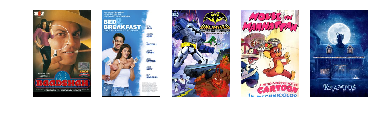

In [4]:
rows, columns = 1, 5
fig = plt.figure()
for i in range(1, rows*columns+1):
    fig.add_subplot(rows, columns, i)
    image = datasets['train'].X[i-1]
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')

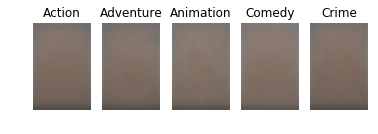

In [15]:
from scipy.spatial.distance import pdist, squareform

mean_posters = np.zeros((19, 278 * 185 * 3))
for i, genre in enumerate(ALL_GENRES_LIST[:5]):
    indices = np.where(genres[:, i] == 1)[0]
    mean_poster = np.mean(posters[indices], axis = 0).astype('uint8')
    mean_posters[i] = mean_poster.flatten()
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(mean_poster.astype('uint8'))
    plt.axis('off')
    plt.title(USED_GENRES_LIST[i])

## Baseline Model (Logistic Regression)

In [ ]:
# Free up memory from previous run(s)
if 'model' in vars() or 'model' in globals():
    del model
tf.reset_default_graph()

model = LogisticRegression(
    USED_GENRES_LIST,
    label_probabilities,
    datasets['train'].X.shape[1:],
    resize_shape = (70, 45)
)

model.train(
    datasets['train'],
    datasets['valid'],
    num_epochs = 10,
    batch_size = 100,
    verbose=True
)

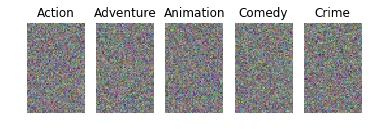

In [20]:
W = model.get_weights()
#W = np.reshape(W, (278, 185, 3, len(USED_GENRES_LIST)))
W = np.reshape(W, (70, 45, 3, len(USED_GENRES_LIST)))
#W = np.reshape(W, (32, 32, 3, len(USED_GENRES_LIST)))

W_min, W_max = np.min(W), np.max(W)
for i in range(len(USED_GENRES_LIST[:5])):
    plt.subplot(1, 5, i + 1)
    # Rescale the weights to be between 0 and 255
    W_img = 255.0 * (W[:, :, :, i].squeeze() - W_min) / (W_max - W_min)
    plt.imshow(W_img.astype('uint8'))
    plt.axis('off')
    plt.title(USED_GENRES_LIST[i])

## Baseline Model (Fully Connected Network)

In [ ]:
# Free up memory from previous run(s)
if 'model' in vars() or 'model' in globals():
    del model
tf.reset_default_graph()

model = FCModel(
    USED_GENRES_LIST,
    label_probabilities,
    datasets['train'].X.shape[1:],
    hidden_layer_sizes = [128, 128],
    #resize_shape = (70, 45)
)

model.train(
    datasets['train'],
    datasets['valid'],
    num_epochs = 10,
    batch_size = 50,
    verbose=True
)

## CNN Model

In [4]:
# Free up memory from previous run(s)
if 'model' in vars() or 'model' in globals():
    del model
    tf.reset_default_graph()

model = CNNModel(
    USED_GENRES_LIST,
    label_probabilities,
    posters.shape[1:],
    filter_counts = [32, 32, 64, 64, 128, 128],
    unit_counts = [1024],
    resize_shape = (70,45) #(32, 32)
)

model.train(
    datasets['train'],
    datasets['valid'],
    num_epochs = 10,
    batch_size = 50,
    eta = 1e-4,
    augmentation = False,
    saving = False,
    verbose = True,
)

Initializing model...Done.
Training Model...
Epoch #1 out of 10: 
444/444 [==============================] - 34s - Train Loss: 1.5001    
Validation Loss: 1.4894 *
------------------------------------------------------------
|      Genre      | Accuracy | Precision | Recall |   F1   |
------------------------------------------------------------
| Action          |  0.6565  |   0.2362  | 0.4288 | 0.3046 |
| Adventure       |  0.2692  |   0.1096  | 0.8851 | 0.1950 |
| Animation       |  0.1471  |   0.0702  | 0.9694 | 0.1309 |
| Comedy          |  0.3976  |   0.3524  | 0.9702 | 0.5170 |
| Crime           |  0.7813  |   0.1615  | 0.2608 | 0.1995 |
| Documentary     |  0.7425  |   0.0817  | 0.3452 | 0.1321 |
| Drama           |  0.5522  |   0.4941  | 0.2780 | 0.3558 |
| Family          |  0.3528  |   0.0986  | 0.9398 | 0.1784 |
| Fantasy         |  0.2251  |   0.0684  | 0.8772 | 0.1269 |
| History         |  0.0572  |   0.0379  | 0.9880 | 0.0731 |
| Horror          |  0.8200  |   0.3026  | 

KeyboardInterrupt: 

In [ ]:
graph = tf.get_default_graph()

#for n in graph.as_graph_def().node:
#    print(n.name)

W = graph.get_tensor_by_name('conv2d/kernel:0').eval(session=model.session)

W_min, W_max = np.min(W), np.max(W)
for i in range(W.shape[-1]):
    plt.subplot(8, 8, i + 1)
    # Rescale the weights to be between 0 and 255
    W_img = 255.0 * (W[:, :, :, i].squeeze() - W_min) / (W_max - W_min)
    plt.imshow(W_img.astype('uint8'))
    plt.axis('off')


[0.6922373  0.14007775 0.0731741  0.07617634 0.8007965  0.5598451
 0.50221074 0.02080376 0.50549906 0.6850289  0.9344661  0.62448305
 0.92264175 0.12883061 0.66867286 0.32213357 0.91015065 0.6438213
 0.17536059]
[0.70495003 0.14910164 0.07560497 0.08875278 0.80088294 0.52924824
 0.5077211  0.0217074  0.4914269  0.6987933  0.9254726  0.60755634
 0.9125502  0.13966663 0.64644134 0.32818878 0.8996835  0.6400545
 0.3675259 ]
[0.71432567 0.15736134 0.07664552 0.10068957 0.80335724 0.50644827
 0.5150907  0.02200538 0.476364   0.70783263 0.9182027  0.5891056
 0.9035019  0.14801097 0.6282251  0.33200046 0.89315957 0.6323061
 0.593763  ]
[0.72576964 0.16497521 0.07712135 0.11145408 0.8065893  0.4824676
 0.5179451  0.02205709 0.46343648 0.71346956 0.91098976 0.56952584
 0.89575726 0.15486276 0.61322063 0.33579695 0.88732415 0.6205272
 0.77965534]
[0.7376674  0.17335281 0.07657801 0.12045412 0.8107753  0.4557967
 0.52431566 0.02197241 0.44740838 0.7210577  0.9047157  0.5497434
 0.8880455  0.16095

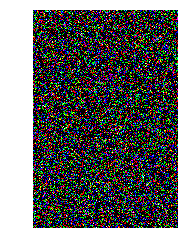

In [28]:
session = model.session
ideal_genre_index = USED_GENRES_LIST.index('Western')
X_fooling = np.random.randn(1, 278, 185, 3)


learning_rate = 1
gradient = tf.gradients(model.output[0, ideal_genre_index], model.X_placeholder)[0]
while True:
    scores, grad = session.run((model.output[0], gradient), {
        model.X_placeholder: X_fooling,
        model.is_training : False,
    })
    print(scores)
    if np.argmax(scores) == ideal_genre_index: break   
    X_fooling += learning_rate * grad / np.linalg.norm(grad)

plt.imshow(X_fooling[0].astype('uint8'))
plt.axis('off')
plt.show()

## Transfer Learning Model

In [ ]:
import keras
model_name = 'ResNet50'

# Free up memory from previous run(s)
tf.reset_default_graph()
keras.backend.clear_session()

if model_name == 'VGG19':
    from keras.applications.vgg19 import VGG19
    pretrained_model = VGG19(weights='imagenet', include_top=False)
    preprocess_fn = keras.applications.vgg19.preprocess_input

elif model_name == 'InceptionV3':
    from keras.applications.inception_v3 import InceptionV3
    pretrained_model = InceptionV3(weights='imagenet', include_top=False)
    preprocess_fn = keras.applications.inception_v3.preprocess_input

elif model_name == 'ResNet50':
    from keras.applications.resnet50 import ResNet50
    pretrained_model = ResNet50(weights='imagenet', include_top=False)
    preprocess_fn = keras.applications.resnet50.preprocess_input

else:
    print('INVALID MODEL NAME: {0}'.format(model_name))


def build_feature_datasets(datasets, pretrained_model, preprocess_fn):
    new_datasets = {}
    for dataset_name in ['train', 'valid', 'test']:
        newX = pretrained_model.predict(preprocess_fn(datasets[dataset_name].X))
        new_datasets[dataset_name] = Dataset(
            newX,
            datasets[dataset_name].y,
            mean = np.zeros_like(newX[0]),
            std = np.ones_like(newX[0]),
        )
        print('{0}: {1}'.format(dataset_name, newX.shape))
    return new_datasets

feature_datasets = build_feature_datasets(datasets, pretrained_model, preprocess_fn)

In [24]:
# Free up memory from previous run(s)
if 'model' in vars() or 'model' in globals():
    del model
    tf.reset_default_graph()

model = FCModel(
    USED_GENRES_LIST,
    label_probabilities,
    feature_datasets['train'].X.shape[1:],
    hidden_layer_sizes = [64]
)

model.train(
    feature_datasets['train'],
    feature_datasets['valid'],
    num_epochs = 10,
    batch_size = 200,
    eta = 1e-4,
    saving = False,
    verbose = True,
)

Initializing model...Done.
Training Model...
Epoch #1 out of 10: 
111/111 [==============================] - 11s - Train Loss: 1.3806    
Validation Loss: 1.5856 *
------------------------------------------------------------
|      Genre      | Accuracy | Precision | Recall |   F1   |
------------------------------------------------------------
| Action          |  0.5298  |   0.1813  | 0.4775 | 0.2628 |
| Adventure       |  0.6078  |   0.0985  | 0.3581 | 0.1544 |
| Animation       |  0.8443  |   0.0907  | 0.1497 | 0.1130 |
| Comedy          |  0.5242  |   0.3557  | 0.5322 | 0.4264 |
| Crime           |  0.5071  |   0.1017  | 0.4741 | 0.1674 |
| Documentary     |  0.6182  |   0.0646  | 0.4246 | 0.1121 |
| Drama           |  0.5082  |   0.4476  | 0.4501 | 0.4489 |
| Family          |  0.8824  |   0.0153  | 0.0090 | 0.0114 |
| Fantasy         |  0.8939  |   0.0848  | 0.0667 | 0.0747 |
| History         |  0.6290  |   0.0482  | 0.4731 | 0.0875 |
| Horror          |  0.6184  |   0.1557  | 

111/111 [==============================] - 11s - Train Loss: 0.7380    
Validation Loss: 1.7383 
------------------------------------------------------------
|      Genre      | Accuracy | Precision | Recall |   F1   |
------------------------------------------------------------
| Action          |  0.6168  |   0.1799  | 0.3325 | 0.2334 |
| Adventure       |  0.7134  |   0.0860  | 0.1937 | 0.1191 |
| Animation       |  0.9047  |   0.0426  | 0.0204 | 0.0276 |
| Comedy          |  0.5326  |   0.3000  | 0.3051 | 0.3025 |
| Crime           |  0.7243  |   0.0923  | 0.1853 | 0.1232 |
| Documentary     |  0.6112  |   0.0550  | 0.3611 | 0.0954 |
| Drama           |  0.4699  |   0.4437  | 0.7549 | 0.5590 |
| Family          |  0.9067  |   0.0233  | 0.0060 | 0.0096 |
| Fantasy         |  0.9160  |   0.0686  | 0.0246 | 0.0362 |
| History         |  0.8468  |   0.0395  | 0.1317 | 0.0608 |
| Horror          |  0.7423  |   0.1438  | 0.1712 | 0.1563 |
| Music           |  0.9347  |   0.0417  | 0.0380

KeyboardInterrupt: 